In [1]:
# All Includes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics ,preprocessing
import pandas as pd
import itertools
import os
from sklearn.metrics import confusion_matrix

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    'AccX',
    'AccY', 
    'AccZ', 
    'GyroX',
    'GyroY', 
    'GyroZ'
]

# Output classes to learn how to classify
LABELS = ['walking',
        'walking upstairs',
        'walking downstairs',
        'sitting',
        'standing',
        'laying']
RAW_DATA_PATH = "../G9_data/sippets/"
SUBJECT_LIST = [  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26]


In [4]:
def load_data(Snippet_paths, n = 128):
    X_signals = []
    y_signals = []
    usecols = INPUT_SIGNAL_TYPES + ['label']
    for snippet_path in Snippet_paths:
        df = pd.read_csv(snippet_path, usecols=usecols)
        y_signals.append(np.array(df['label'][0].reshape(1), dtype=np.int32))
        df = df[INPUT_SIGNAL_TYPES]
        c = df.values.reshape(df.shape[0], df.shape[1])
        X_signals.append(c)
        
    return np.asarray(X_signals), np.asarray(y_signals)






## Utility functions for training:


In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1,lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [6]:
'''n = ''
subject_no = 5
Snippet_paths_train =[]
Snippet_paths_test =[]
for fol in LABELS:
    folder = RAW_DATA_PATH+'/'+fol+'/'
    for root,dirs,files in os.walk(folder):
        for file_ in files:
            if file_.endswith(".csv"):
                if not int(file_.split("_")[0]) == subject_no:
                    Snippet_paths_train.append(folder+file_)
                elif int(file_.split("_")[0]) == subject_no:
                    Snippet_paths_test.append(folder+file_)

X_train,y_train = load_data(Snippet_paths_train,128)

X_test,y_test = load_data(Snippet_paths_test,128)

y_test = y_test - 1
y_train = y_train - 1



import keras
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)
X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
        padding='pre', truncating='pre', value=0.)

# Scaling
def scale_data(X_train, X_test):
    X_train_2d = X_train.transpose(2,0,1).reshape(6,-1).transpose()
    X_test_2d = X_test.transpose(2,0,1).reshape(6,-1).transpose()
    scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(X_train_2d)
    X_train_scaled =  np.array([scaler.transform(X_train[i,:,:]) for i in range(X_train.shape[0])])
    X_test_scaled  =  np.array([scaler.transform(X_test[i,:,:]) for i in range(X_test.shape[0])])
    return X_train_scaled, X_test_scaled

X_train_used, X_test_used = X_train_padded, X_test_padded'''

'n = \'\'\nsubject_no = 5\nSnippet_paths_train =[]\nSnippet_paths_test =[]\nfor fol in LABELS:\n    folder = RAW_DATA_PATH+\'/\'+fol+\'/\'\n    for root,dirs,files in os.walk(folder):\n        for file_ in files:\n            if file_.endswith(".csv"):\n                if not int(file_.split("_")[0]) == subject_no:\n                    Snippet_paths_train.append(folder+file_)\n                elif int(file_.split("_")[0]) == subject_no:\n                    Snippet_paths_test.append(folder+file_)\n\nX_train,y_train = load_data(Snippet_paths_train,128)\n\nX_test,y_test = load_data(Snippet_paths_test,128)\n\ny_test = y_test - 1\ny_train = y_train - 1\n\n\n\nimport keras\nX_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=128, dtype=\'float64\',\n        padding=\'pre\', truncating=\'pre\', value=0.)\nX_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype=\'float64\',\n        padding=\'pre\', truncating=\'pre\', value=0.)\n\n# Scalin

In [7]:
df = pd.read_csv("/home/ahmet/notebooks/data/G9_data/processed.csv")
df.dropna(axis=0, how='any', inplace=True)

In [8]:
df.head()

,CorAccXAccY_corr,CorAccXAccZ_corr,CorAccYAccZ_corr,CorGyroXGyroY_corr,CorGyroXGyroZ_corr,CorGyroYGyroZ_corr,accX_aoa,accX_apf,accX_ate,accX_max,...,gyroZ_ate,gyroZ_max,gyroZ_mean,gyroZ_min,gyroZ_minmax,gyroZ_rms,gyroZ_std,label,start,subject_id
0,-0.191494,-0.018550,-0.291556,0.727880,0.461031,0.569434,-6.158093,0.043011,24.333333,-6.009446,...,40.000000,0.017993,0.000428,-0.018226,0.036219,0.007781,0.007769,5.0,2018-01-16 06:30:12.029,15.0
2,0.346551,-0.330945,-0.692002,-0.124647,0.323075,0.331159,-9.611379,0.040000,29.000000,-9.457097,...,24.333333,0.056933,0.000213,-0.028820,0.085754,0.013421,0.013419,5.0,2018-01-16 04:35:14.010,14.0
4,-0.163335,-0.209158,-0.039511,0.581457,-0.036526,-0.345909,-9.551191,0.038835,30.333333,-9.270349,...,37.500000,0.191847,-0.004006,-0.200170,0.392017,0.081773,0.081675,5.0,2017-12-08 09:29:15.016,1.0
5,-0.067963,0.216787,0.847867,0.622559,-0.474301,-0.378248,-5.000725,0.034091,23.500000,-4.831499,...,30.500000,0.057916,-0.001733,-0.048611,0.106526,0.018821,0.018741,5.0,2018-01-16 04:04:24.018,13.0
7,0.425971,0.060016,-0.080594,0.250882,0.395483,0.499603,-9.692078,0.031250,33.000000,-8.920795,...,32.000000,0.530685,0.010730,-0.344430,0.875115,0.205208,0.204927,5.0,2017-12-20 07:21:44.015,11.0


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(X, y, look_back=3):

    dataX, dataY = [], []
    for i in range(look_back , len(X)):
        a = X[i-look_back:i, :]
        b = y[i]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [33]:
df_training = df[np.logical_and(df['subject_id']!=15,df['subject_id']!=14 )]
df_test = df[np.logical_or(df['subject_id']==15, df['subject_id']==14 )]

In [34]:
X_test_used = df_test[df_test.columns[:-3]].values
y_test = df_test['label'].values -1
X_train_used = df_training[df_training.columns[:-3]].values
y_train = df_training['label'].values -1

In [12]:
X_test_used, y_test = create_dataset(X_test_used, y_test, look_back=10)
X_train_used, y_train = create_dataset(X_train_used, y_train, look_back=10)

In [13]:
X_train_used.shape, X_test_used.shape, y_train.shape, y_test.shape

((28243, 10, 60), (1910, 10, 60), (28243,), (1910,))

## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [14]:
# Input Data 

training_data_count = len(X_train_used)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test_used)  # 2947 testing series
n_steps = len(X_train_used[0])  # 128 timesteps per series
n_input = len(X_train_used[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 150  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test_used.shape, y_test.shape, np.mean(X_test_used), np.std(X_test_used))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(1910, 10, 60) (1910,) 3.2722786936587966 10.191624910402213
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Let's get serious and build the neural network:

In [15]:
from tensorflow.python.framework import ops
ops.reset_default_graph()



In [16]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Hooray, now train the neural network:

In [17]:
from sklearn.utils import shuffle
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
saver = tf.train.Saver()
# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
# saver.restore(sess, '../Model_saved/model.ckpt')
# print("Model restored from file: %s" % '../Model_saved/model.ckpt')


# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train_used, step, batch_size)
    batch_ys =         one_hot(extract_batch_size(y_train, step, batch_size))
    batch_xs, batch_ys = shuffle(batch_xs, batch_ys, random_state=44)
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)

    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test_used,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test_used,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT on Test Set: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


predictions = one_hot_predictions.argmax(1)


Training iter #1500:   Batch Loss = 2.917132, Accuracy = 0.7839999794960022
PERFORMANCE ON TEST SET: Batch Loss = 5.299158096313477, Accuracy = 0.17539267241954803
Training iter #30000:   Batch Loss = 5.069307, Accuracy = 0.0
PERFORMANCE ON TEST SET: Batch Loss = 3.800581455230713, Accuracy = 0.35811519622802734
Training iter #60000:   Batch Loss = 3.493492, Accuracy = 0.0013333333190530539
PERFORMANCE ON TEST SET: Batch Loss = 3.3677873611450195, Accuracy = 0.35811519622802734
Training iter #90000:   Batch Loss = 3.485875, Accuracy = 0.01133333332836628
PERFORMANCE ON TEST SET: Batch Loss = 3.168515205383301, Accuracy = 0.4188481569290161
Training iter #120000:   Batch Loss = 3.494474, Accuracy = 0.0
PERFORMANCE ON TEST SET: Batch Loss = 3.050868272781372, Accuracy = 0.41937172412872314
Training iter #150000:   Batch Loss = 3.088806, Accuracy = 0.01066666655242443
PERFORMANCE ON TEST SET: Batch Loss = 2.857450485229492, Accuracy = 0.5717277526855469
Training iter #180000:   Batch Loss

Training iter #1530000:   Batch Loss = 1.293644, Accuracy = 0.7706666588783264
PERFORMANCE ON TEST SET: Batch Loss = 1.0792369842529297, Accuracy = 0.7602094411849976
Training iter #1560000:   Batch Loss = 1.578195, Accuracy = 0.6579999923706055
PERFORMANCE ON TEST SET: Batch Loss = 1.0444331169128418, Accuracy = 0.7905759215354919
Training iter #1590000:   Batch Loss = 1.374775, Accuracy = 0.6606666445732117
PERFORMANCE ON TEST SET: Batch Loss = 1.0326294898986816, Accuracy = 0.781675398349762
Training iter #1620000:   Batch Loss = 0.775927, Accuracy = 0.9240000247955322
PERFORMANCE ON TEST SET: Batch Loss = 1.0113236904144287, Accuracy = 0.7863874435424805
Training iter #1650000:   Batch Loss = 0.649906, Accuracy = 0.9746666550636292
PERFORMANCE ON TEST SET: Batch Loss = 0.9827492237091064, Accuracy = 0.7958115339279175
Training iter #1680000:   Batch Loss = 0.656858, Accuracy = 0.9773333072662354
PERFORMANCE ON TEST SET: Batch Loss = 0.9538642168045044, Accuracy = 0.8057591915130615

Training iter #3030000:   Batch Loss = 1.179029, Accuracy = 0.8113333582878113
PERFORMANCE ON TEST SET: Batch Loss = 0.8327247500419617, Accuracy = 0.8115183115005493
Training iter #3060000:   Batch Loss = 1.090665, Accuracy = 0.746666669845581
PERFORMANCE ON TEST SET: Batch Loss = 1.0570670366287231, Accuracy = 0.746073305606842
Training iter #3090000:   Batch Loss = 0.445820, Accuracy = 0.9980000257492065
PERFORMANCE ON TEST SET: Batch Loss = 0.7685472965240479, Accuracy = 0.8287957906723022
Training iter #3120000:   Batch Loss = 0.544348, Accuracy = 0.9666666388511658
PERFORMANCE ON TEST SET: Batch Loss = 0.8439948558807373, Accuracy = 0.8198952674865723
Training iter #3150000:   Batch Loss = 0.755736, Accuracy = 0.8533333539962769
PERFORMANCE ON TEST SET: Batch Loss = 0.785834789276123, Accuracy = 0.8356021046638489
Training iter #3180000:   Batch Loss = 0.472992, Accuracy = 0.981333315372467
PERFORMANCE ON TEST SET: Batch Loss = 0.8166651129722595, Accuracy = 0.8434554934501648
Tr

In [18]:

y_train_one_hot_pred = sess.run(
    [pred],
    feed_dict={
        x: X_train_used,
        y: one_hot(y_train)
    }
)
y_train_pred = y_train_one_hot_pred[0].argmax(1)
tr_accuracy = metrics.accuracy_score(y_train_pred, y_train)
print("FINAL RESULT: " +  \
      ", Training Accuracy = {}".format(tr_accuracy))

FINAL RESULT: , Training Accuracy = 0.9341429734801544


## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


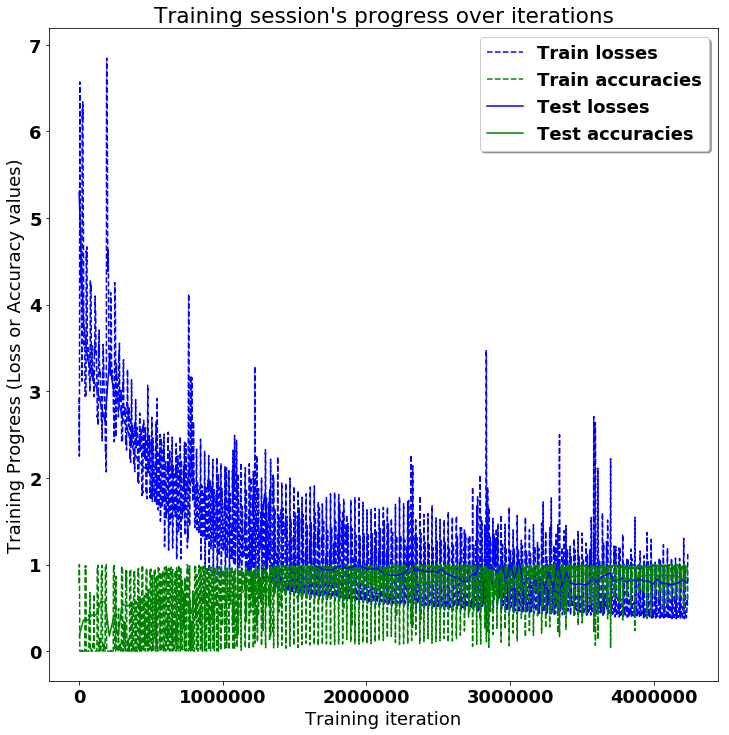

In [19]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

In [20]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: 84.55497622489929%

Precision: 88.0994401106543%
Recall: 84.55497382198953%
f1_score: 83.88916874939217%
Normalized confusion matrix


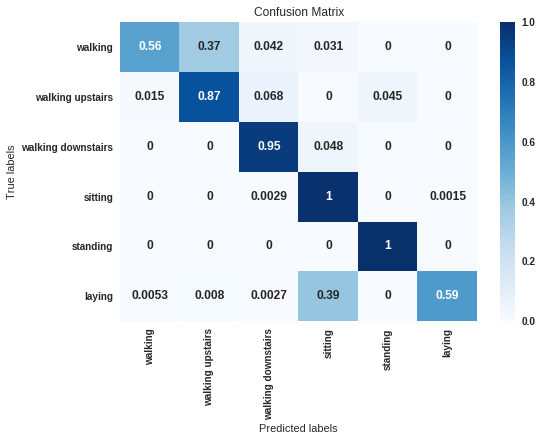

In [21]:
# Results
# predictions = y_train_pred
# y_test = y_train
print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))


confusion_matrix = metrics.confusion_matrix(y_test, predictions)
plot_cm(confusion_matrix, LABELS)
plt.show()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,target_names=LABELS))

                    precision    recall  f1-score   support

           walking       0.97      0.56      0.71       260
  walking upstairs       0.54      0.87      0.66       132
walking downstairs       0.84      0.95      0.89       124
           sitting       0.81      1.00      0.89       684
          standing       0.98      1.00      0.99       335
            laying       1.00      0.59      0.74       375

       avg / total       0.88      0.85      0.84      1910



In [106]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[249   4   4   0   3   0]
 [110  13   3   0   6   0]
 [  1   3 113   5   2   0]
 [  0   0   0 681   0   3]
 [  0   0   0   0 335   0]
 [  4   2   0  71   0 298]]
Normalized confusion matrix
[[0.96 0.02 0.02 0.   0.01 0.  ]
 [0.83 0.1  0.02 0.   0.05 0.  ]
 [0.01 0.02 0.91 0.04 0.02 0.  ]
 [0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.01 0.01 0.   0.19 0.   0.79]]


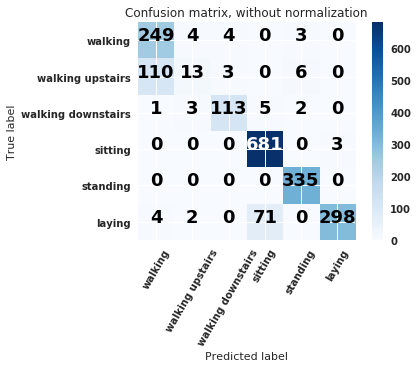

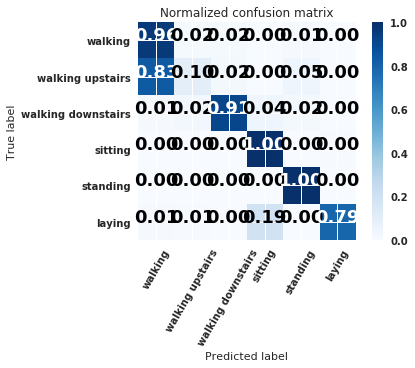

In [107]:
y_pred_all = predictions
y_test_all = y_test
cnf_matrix = confusion_matrix
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS, normalize=True,
                      title='Normalized confusion matrix')
# plt.savefig(save_with_name+'.png')
plt.show()

In [ ]:
np.save('y_test_all', y_test)
np.save('y_pred_all', predictions)

In [35]:
from models import *

In [36]:
model = RNN_classifier(batch_size=30000, n_classes=6, training_iters=150)
X_test, y_test = model.transform_dataset(X_test_used, y_test)
X_training, y_training = model.transform_dataset(X_train_used, y_train)
model.fit(X_training=X_training, y_training= y_training, X_val=X_test, y_val=y_test, transform_data=False)
y_pred = model.predict(X_test, transform_data=False)
y_score = model.predict_proba(X_test, transform_data=False)

Optimization Finished!


Normalized confusion matrix


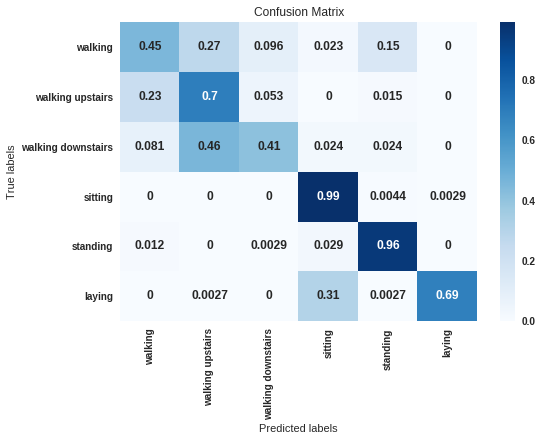

In [37]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plot_cm(confusion_matrix, LABELS)
plt.show()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


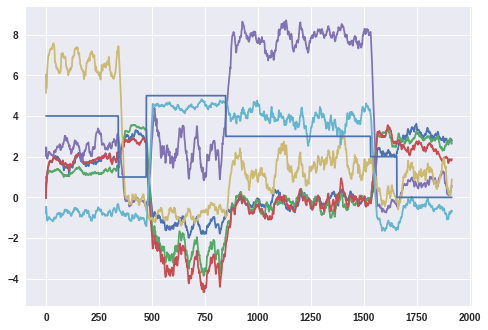

In [40]:
plt.plot(pd.rolling_mean(y_score, 30,min_periods=1))
plt.plot(y_test)